# The Client

The web interface presents a nice and simple way to browse records.
But it is not convenient for programmatic usage.

A Python client is also provided to interact with the server.

Currently, the package is not published to PyPI.
To use the client, one shall clone the repository and install the package locally.

```bash
git clone https://github.com/TLCFEM/motion-base.git
cd motion-base
pip install .[client]
```

Then one can import the client and start using it.

## Creation

The client is designed in an asynchronous way, using the `aiohttp` library.
One shall use the context manager to create a client.

Additional parameters may include:

1. `timeout(float)` - request timeout
2. `semaphore(int)` - number of concurrent requests

```python
async with MBClient('http://localhost:8000', timeout=20, semaphore=10) as client:
    # do something with the client
    ...
```

In [1]:
from rich.pretty import pprint

from mb.client import MBClient


## Query

To query the server, one shall use the `search` method.
The method accepts a query configuration object.
The configuration(s) are `pydantic` models.
For example, to search for 100 records with PGA no less than 200 Gal, one can do the following.

In [2]:
from mb.app.response import PaginationConfig, QueryConfig

async with MBClient("http://170.64.176.26:8000", timeout=20, semaphore=10) as client:
    results = await client.search(
        QueryConfig(min_pga=200, pagination=PaginationConfig(page_size=100))
    )
    pprint(f"Find {len(results)} records. The first one contains looks like this.")
    pprint(results[0])

'Find 100 records. The first one contains looks like this.'

MBRecord(
│   endpoint='/query',
│   id='d7348417-57b8-5f9f-bb88-aaf8f54c2ba4',
│   file_name='20161113_110259_WTMC_20.V2A',
│   category='processed',
│   region='nz',
│   uploaded_by='d41eadf4-5770-5e2f-874f-0f18f543fd73',
│   magnitude=7.53,
│   maximum_acceleration=2969.75,
│   event_time=datetime.datetime(2016, 11, 13, 11, 2, 56),
│   event_location=[173.02, -42.69],
│   depth=15.0,
│   station_code='WTMC',
│   station_location=[173.054, -42.619],
│   station_elevation=None,
│   station_elevation_unit=None,
│   record_time=datetime.datetime(2016, 11, 13, 11, 2, 19),
│   last_update_time=datetime.datetime(2017, 1, 20, 11, 0),
│   sampling_frequency=200.0,
│   sampling_frequency_unit='hertz',
│   duration=209.99,
│   direction='UP',
│   scale_factor=1e-05,
│   raw_data=None,
│   raw_data_unit=None,
│   offset=None,
│   processed_data_unit=None,
│   time_interval=None,
│   waveform=None,
│   frequency_interval=None,
│   spectrum=None,
│   period=None,
│   displacement_spectrum=None,
│   velocity_spectrum=None,
│   acceleration_spectrum=None
)

A list of `MBRecord` objects will be returned.
The search method only returns the metadata of the records.
As one may have observed, the `MBRecord` object does not contain the actual data.

More query parameters can be applied.
The actual amount of records returned may be less than the specified amount, if there are not enough records to return.

In [3]:
async with MBClient("http://170.64.176.26:8000", timeout=20, semaphore=10) as client:
    results = await client.search(
        QueryConfig(
            min_pga=300, min_magnitude=7, pagination=PaginationConfig(page_size=800)
        )
    )
    pprint(f"Find {len(results)} records.")

'Find 530 records.'

## Download

The download method accepts a record ID as found in the metadata.

In [4]:
from mb.client import MBRecord


example_record: MBRecord
async with MBClient("http://170.64.176.26:8000", timeout=20, semaphore=10) as client:
    await client.download(results[0].id)
    for r in client:
        example_record = r
        pprint(r, max_length=10)

Successfully downloaded file d7348417-57b8-5f9f-bb88-aaf8f54c2ba4. [1/0].

MBRecord(
│   endpoint='/waveform',
│   id='d7348417-57b8-5f9f-bb88-aaf8f54c2ba4',
│   file_name='20161113_110259_WTMC_20.V2A',
│   category='processed',
│   region='nz',
│   uploaded_by='d41eadf4-5770-5e2f-874f-0f18f543fd73',
│   magnitude=7.53,
│   maximum_acceleration=2969.75,
│   event_time=datetime.datetime(2016, 11, 13, 11, 2, 56),
│   event_location=[173.02, -42.69],
│   depth=15.0,
│   station_code='WTMC',
│   station_location=[173.054, -42.619],
│   station_elevation=None,
│   station_elevation_unit=None,
│   record_time=datetime.datetime(2016, 11, 13, 11, 2, 19),
│   last_update_time=datetime.datetime(2017, 1, 20, 11, 0),
│   sampling_frequency=200.0,
│   sampling_frequency_unit='hertz',
│   duration=209.99,
│   direction='UP',
│   scale_factor=1e-05,
│   raw_data=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... +41990],
│   raw_data_unit='millimeter / second ** 2',
│   offset=0.0,
│   processed_data_unit='millimeter / second ** 2',
│   time_interval=0.005,
│   waveform=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ... +41990],
│   frequency_interval=None,
│   spectrum=None,
│   period=None,
│   displacement_spectrum=None,
│   velocity_spectrum=None,
│   acceleration_spectrum=None
)

The downloaded records are internally stored.
After the call to the download method, the records can be accessed by iterating over the client object.
One can observe that now the `MBRecord` object contains the actual data, both the raw data (typically integer) and the floating point data.

## Plot

One can now plot the waveform by calling the `plot_waveform` method.
It returns a `matplotlib` figure object.

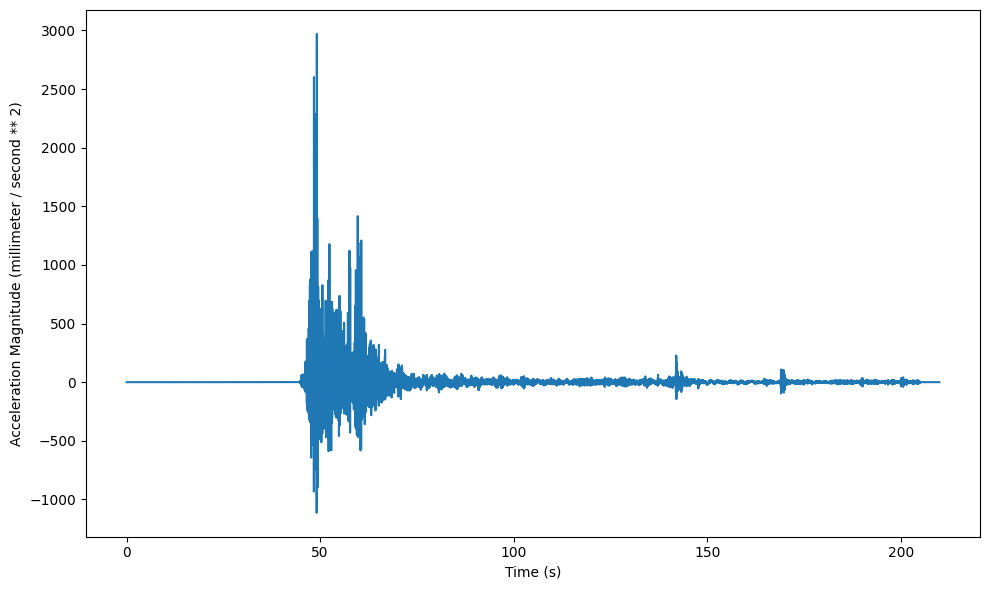

In [5]:
example_record.plot_waveform()
pass

To plot frequency spectrum, one can call the `plot_spectrum` method.

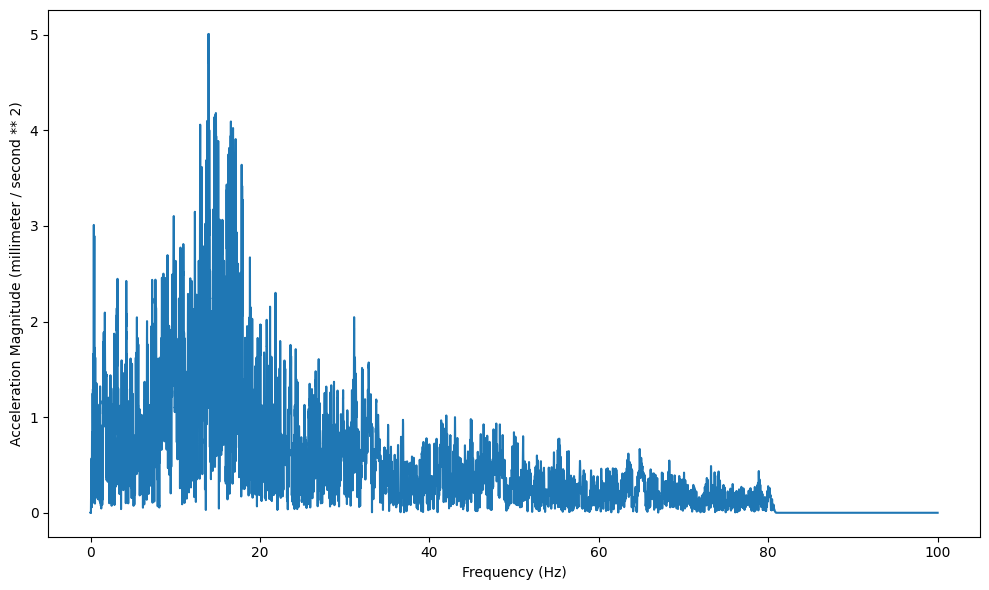

In [6]:
example_record.plot_spectrum()
pass

To plot response spectra, one can call the `plot_response_spectrum` method.

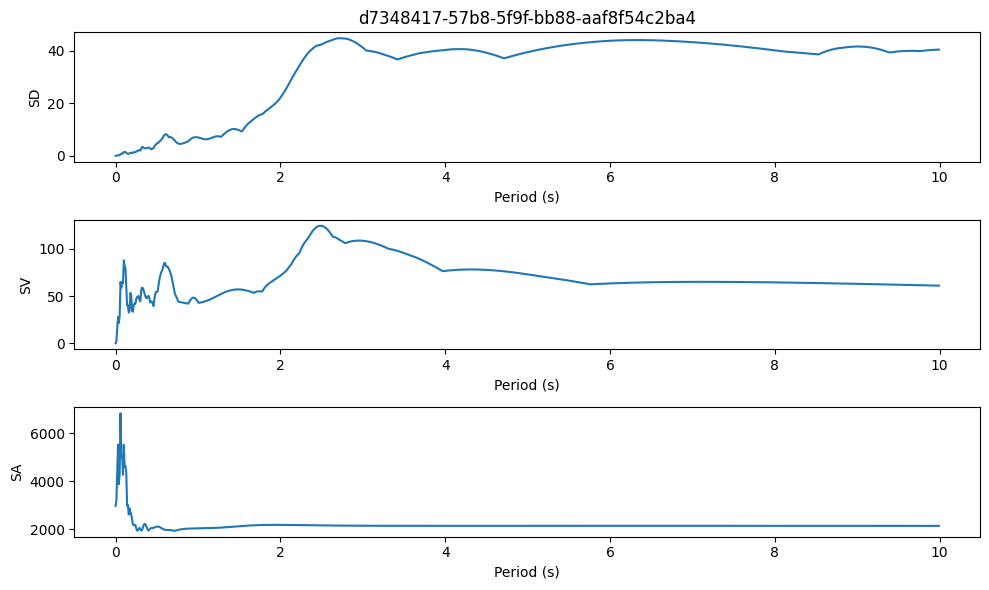

In [7]:
example_record.plot_response_spectrum()
pass


Since only waveform is retrieved from the server, all necessary processing is done locally on the client side.
It means one can also apply custom processing to the waveform data.

For example, one can customise the computation of response spectra by providing a damping ratio and a list of periods.

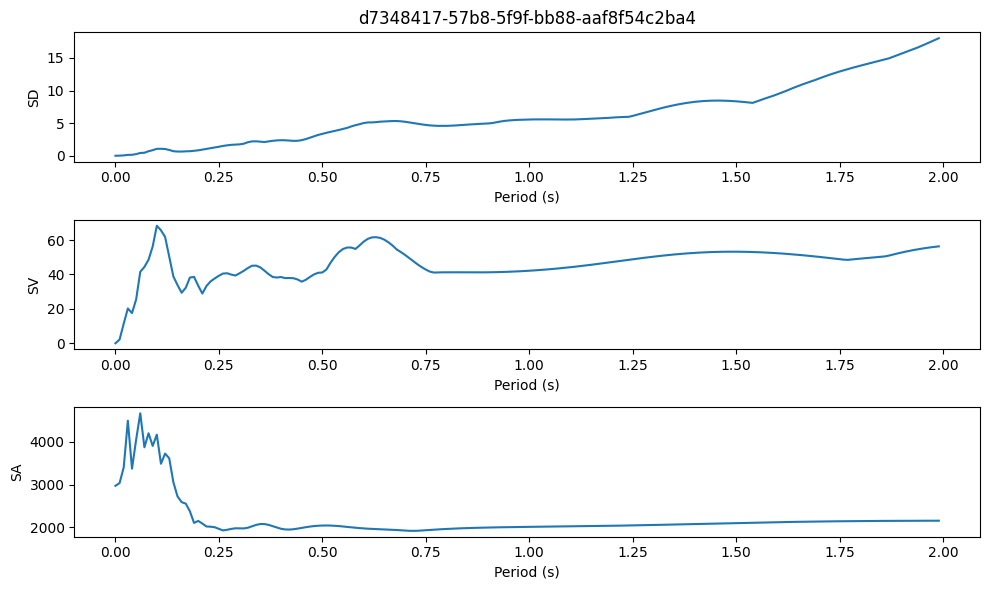

In [8]:
import numpy as np


example_record.plot_response_spectrum(0.1, np.arange(0, 2, 0.01))
pass

It shall be pointed out that, the frequency spectrum and response spectra are computed from the current waveform data.
The waveform data can be modified by applying filters or other processing.

For example, one can normalise the record to have a unit amplitude.

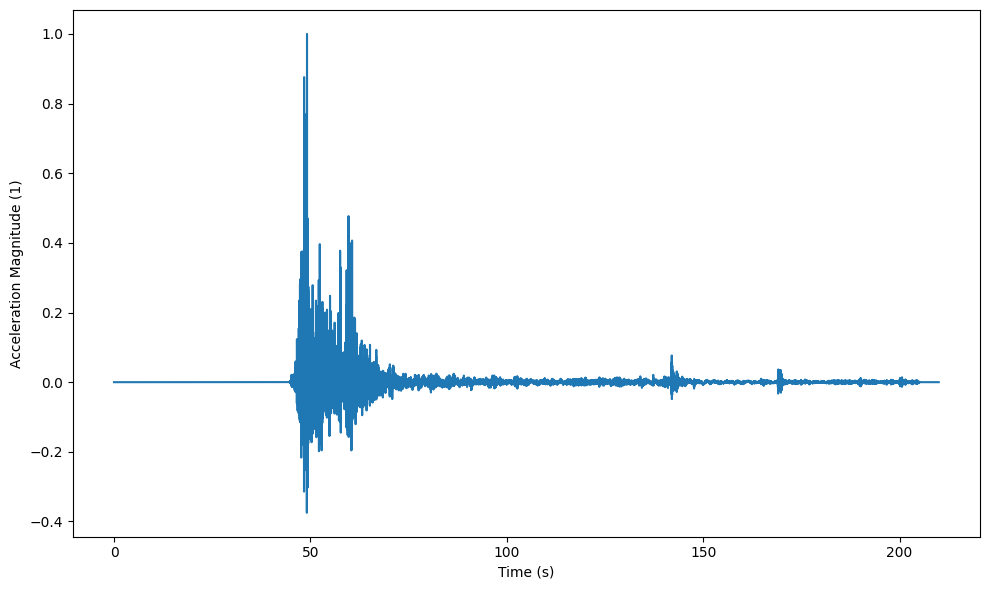

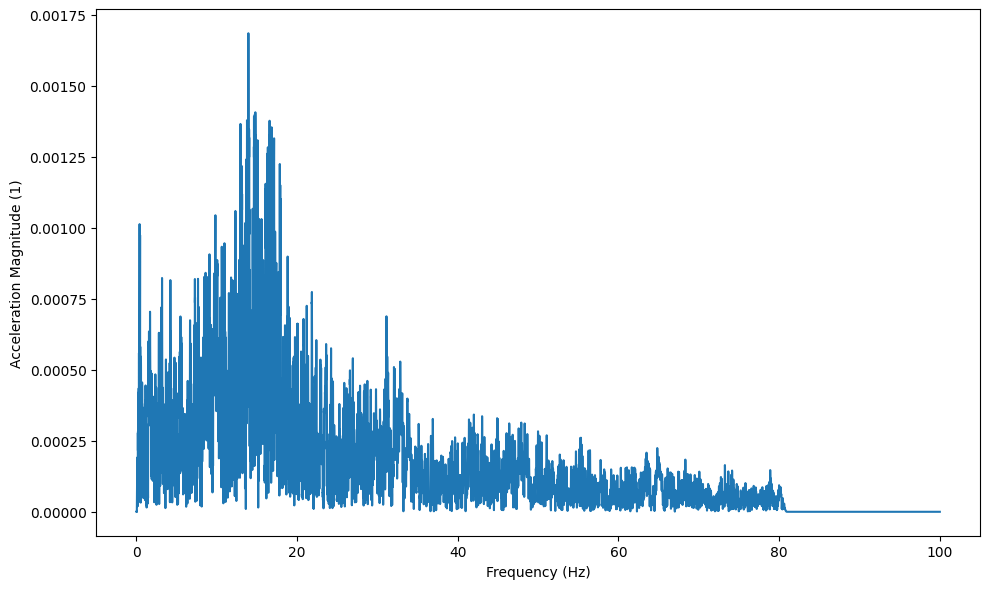

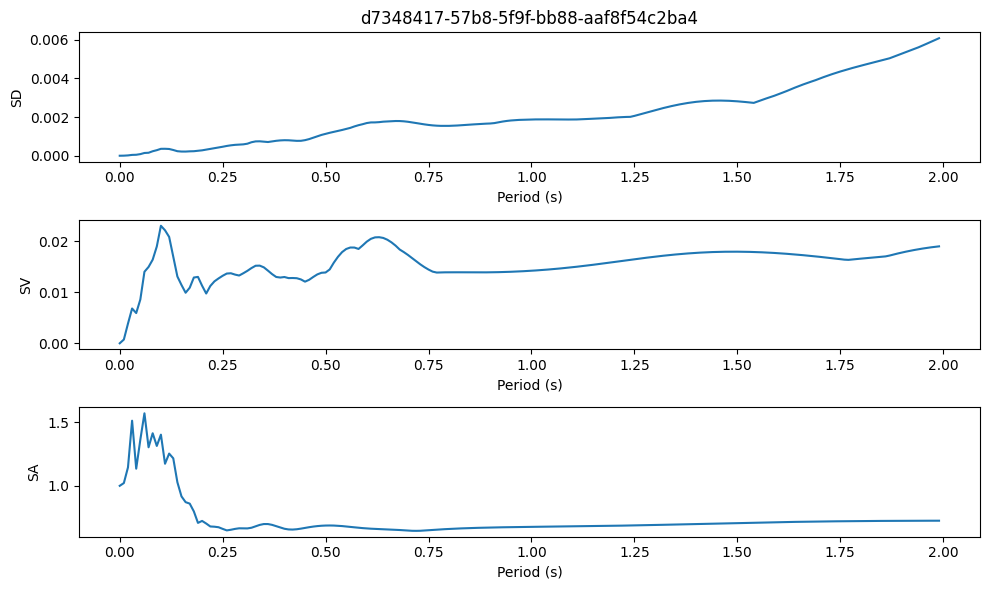

In [9]:
example_record.normalise()
example_record.plot_waveform()
example_record.plot_spectrum()
example_record.plot_response_spectrum(0.1, np.arange(0, 2, 0.01))
pass